In [1]:
# utility
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

dataset = arff.loadarff('ames_housing.arff')
data = pd.DataFrame(dataset[0])

print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

Number of rows in the data: 2930
Number of columns in the data: 81


## Make data split


In [2]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20)

data.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',141.0,31770.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,5.0,2010.0,b'WD ',b'Normal',215000.0,-93.619754,42.054035
1,b'One_Story_1946_and_Newer_All_Styles',b'Residential_High_Density',80.0,11622.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,6.0,2010.0,b'WD ',b'Normal',105000.0,-93.619756,42.053014
2,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',81.0,14267.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'Gar2',12500.0,6.0,2010.0,b'WD ',b'Normal',172000.0,-93.619387,42.052659
3,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',93.0,11160.0,b'Pave',b'No_Alley_Access',b'Regular',b'Lvl',b'AllPub',b'Corner',...,b'No_Fence',b'None',0.0,4.0,2010.0,b'WD ',b'Normal',244000.0,-93.617320,42.051245
4,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',74.0,13830.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Lvl',b'AllPub',b'Inside',...,b'Minimum_Privacy',b'None',0.0,3.0,2010.0,b'WD ',b'Normal',189900.0,-93.638933,42.060899


## One hot encoding
We are going to OneHotEncode the discrete variable

In [29]:
from sklearn.preprocessing import OneHotEncoder

#feature trasformate in livello

#tenere solo le feature numeriche

numerical_idx = []

new_X_train = X_train[ numerical_idx ].apply(pd.to_numeric, errors='coerce')

new_X_test = X_test[ numerical_idx ].apply(pd.to_numeric, errors='coerce')

#TODO: controllare 'fair', 'Typical'
def refineData(df):
    replace = {
        "Kitchen_Qual": {b'Poor': 0, b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Utilities": {b'AllPub': 1, b'NoSewr': 2, b'NoSeWa': 3},
        "Land_Slope": {b'Gtl': 1, b'Mod': 2, b'Sev': 3},
        "Overall_Qual":{b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5, b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Overall_Cond":{b'Very_Poor': 1, b'Poor': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5, b'Fair': 6, b'Good': 7, b'Very_Good': 8, b'Excellent': 9, b'Very_Excellent': 10},
        "Exter_Qual":{b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Exter_Cond":{b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
    }
    data = df.replace(replace)
    return data

data = refineData(data)

categorical_idx = ['MS_SubClass','MS_Zoning','Street','Alley','Lot_Shape','Land_Contour','Lot_Config','Land_Slope','Neighborhood','Condition_1','Condition_2','Bldg_Type','House_Style','Roof_Style','Roof_Matl','Exterior_1st','Exterior_2nd','Mas_Vnr_Type','Foundation','Bsmt_Qual','Bsmt_Cond','Bsmt_Exposure','BsmtFin_Type_1','BsmtFin_Type_2','Heating','Heating_QC','Central_Air','Electrical','Functional','Fireplace_Qu','Garage_Type','Garage_Finish','Garage_Qual','Garage_Cond','Paved_Drive','Pool_QC','Fence','Misc_Feature','Sale_Type','Sale_Condition']

oh = OneHotEncoder(sparse=False, handle_unknown='ignore', min_frequency=0.15, max_categories=5)
oh.fit(X_train[categorical_idx])

X_train_e = oh.transform(X_train[categorical_idx])
X_test_e = oh.transform(X_test[categorical_idx])

for i,col in enumerate(oh.get_feature_names_out()):
    new_X_train[col] = X_train_e[:,i]

for i,col in enumerate(oh.get_feature_names_out()):
    new_X_test[col] = X_test_e[:,i]

new_X_train.columns

Index(['MS_SubClass_b'One_Story_1946_and_Newer_All_Styles'',
       'MS_SubClass_b'Two_Story_1946_and_Newer'',
       'MS_SubClass_infrequent_sklearn',
       'MS_Zoning_b'Residential_Low_Density'',
       'MS_Zoning_b'Residential_Medium_Density'',
       'MS_Zoning_infrequent_sklearn', 'Street_b'Pave'',
       'Street_infrequent_sklearn', 'Alley_b'No_Alley_Access'',
       'Alley_infrequent_sklearn', 'Lot_Shape_b'Regular'',
       'Lot_Shape_b'Slightly_Irregular'', 'Lot_Shape_infrequent_sklearn',
       'Land_Contour_b'Lvl'', 'Land_Contour_infrequent_sklearn',
       'Lot_Config_b'Corner'', 'Lot_Config_b'Inside'',
       'Lot_Config_infrequent_sklearn', 'Land_Slope_b'Gtl'',
       'Land_Slope_infrequent_sklearn', 'Neighborhood_b'North_Ames'',
       'Neighborhood_infrequent_sklearn', 'Condition_1_b'Norm'',
       'Condition_1_infrequent_sklearn', 'Condition_2_b'Norm'',
       'Condition_2_infrequent_sklearn', 'Bldg_Type_b'OneFam'',
       'Bldg_Type_infrequent_sklearn', 'House_Style_b

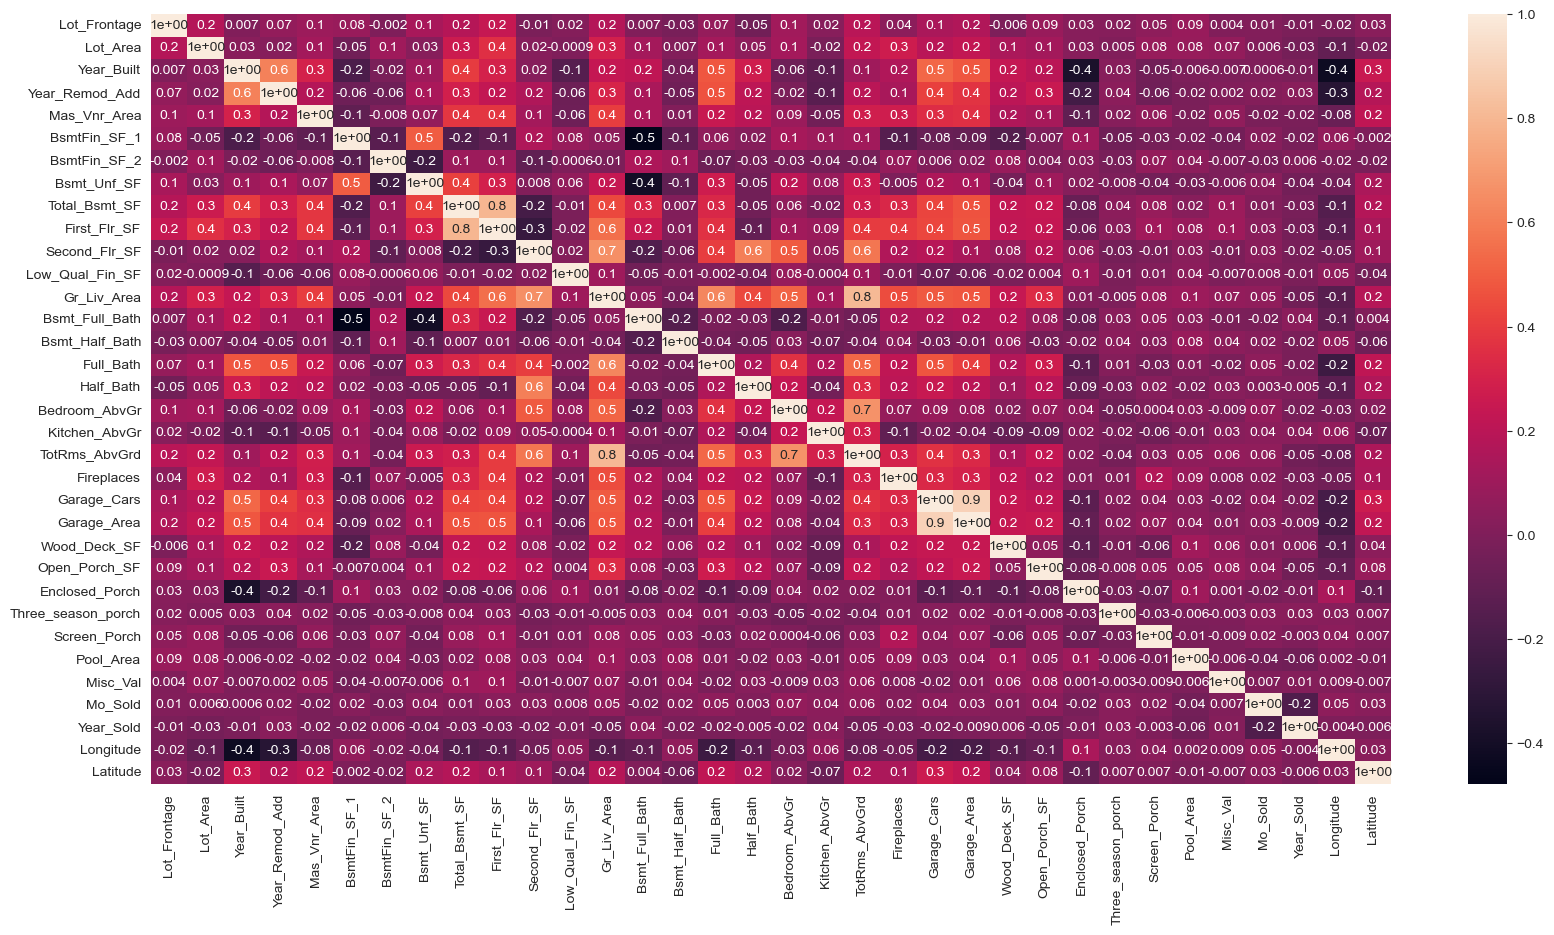

In [21]:
#figure size
plt.figure(figsize=(20, 10))
#heat map for correlation coefficient
sns.heatmap(X_train.corr(), annot=True, fmt="0.1")
plt.show()

# Plot some plot for correlatted features

In [ ]:

fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.Gr_Liv_Area, data.TotRms_AbvGrd, c = data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('Gr_Liv_Area')
axs.set_ylabel('TotRms_AbvGrd')
fig.colorbar(pos)
plt.show()


fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.First_Flr_SF, data.Total_Bsmt_SF, c = data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('First_Flr_SF')
axs.set_ylabel('Total_Bsmt_SF')
fig.colorbar(pos)
plt.show()

In [ ]:
#figure size
plt.figure(figsize=(20, 10))
#heat map for correlation coefficient
sns.heatmap(data_oh.corr(), annot=True, fmt="0.1")
plt.show()